# Importação das bibliotecas necessárias



In [15]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from dataclasses import dataclass
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Estrutura de Dados para Recomendações

1. `BookRecommendation`: Uma classe de dados (dataclass) que representa uma recomendação de livro, contendo o título e o score de similaridade.

In [4]:
@dataclass
class BookRecommendation:
    """Representa uma recomendação de livro com seu título e score de similaridade."""
    title: str
    similarity_score: float

# Visualizando como seria uma recomendação
exemplo_recomendacao = BookRecommendation(title="Harry Potter", similarity_score=0.95)
print(f"Exemplo de recomendação: {exemplo_recomendacao}")

Exemplo de recomendação: BookRecommendation(title='Harry Potter', similarity_score=0.95)


## 2. Carregamento e Exploração dos Dados

O sistema utiliza dois datasets principais:
- `BX-Books.csv`: Contém informações sobre os livros (ISBN, título, autor)
- `BX-Book-Ratings.csv`: Contém as avaliações dos usuários para os livros

Vamos carregar esses datasets e explorar suas características:

In [ ]:

books_file = 'dataset_books/BX-Books.csv'
ratings_file = 'dataset_books/BX-Book-Ratings.csv'

df_books = pd.read_csv(
    books_file,
    encoding="ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'}
)

df_ratings = pd.read_csv(
    ratings_file,
    encoding="ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'}
)


print("Primeiras linhas do dataset de livros:")
display(df_books.head())

print("\nPrimeiras linhas do dataset de avaliações:")
display(df_ratings.head())


print("\nInformações sobre o dataset de livros:")
print(f"Número de livros: {df_books.shape[0]}")
print(f"Colunas: {df_books.columns.tolist()}")

print("\nInformações sobre o dataset de avaliações:")
print(f"Número de avaliações: {df_ratings.shape[0]}")
print(f"Colunas: {df_ratings.columns.tolist()}")

Primeiras linhas do dataset de livros:


,isbn,title,author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber



Primeiras linhas do dataset de avaliações:


,user,isbn,rating
0,276725,034545104X,0.0
1,276726,0155061224,5.0
2,276727,0446520802,0.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0



Informações sobre o dataset de livros:
Número de livros: 271379
Colunas: ['isbn', 'title', 'author']

Informações sobre o dataset de avaliações:
Número de avaliações: 1149780
Colunas: ['user', 'isbn', 'rating']


### Análise Exploratória dos Dados

Vamos analisar a distribuição das avaliações e outras características importantes dos datasets:

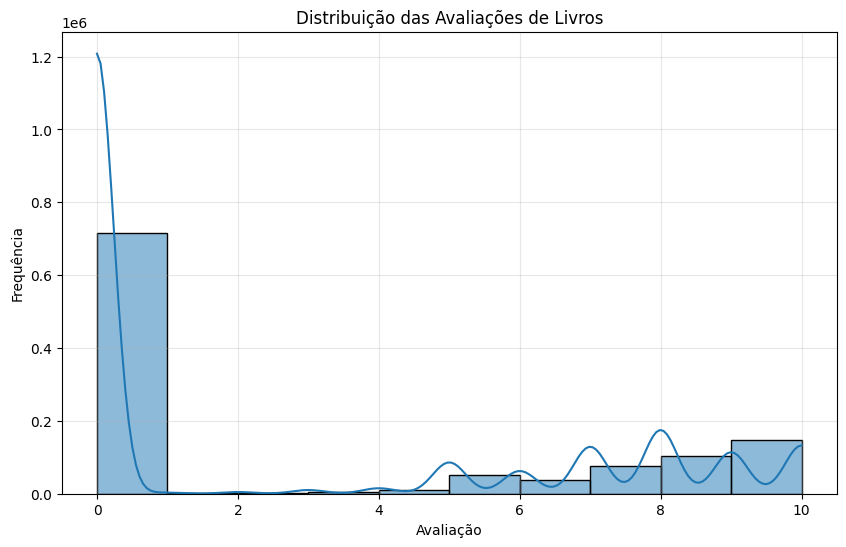

In [7]:

plt.figure(figsize=(10, 6))
sns.histplot(df_ratings['rating'], bins=10, kde=True)
plt.title('Distribuição das Avaliações de Livros')
plt.xlabel('Avaliação')
plt.ylabel('Frequência')
plt.grid(True, alpha=0.3)
plt.show()



## 3. Pré-processamento dos Dados

O sistema realiza várias etapas de pré-processamento para melhorar a qualidade das recomendações:

1. **Remoção de valores nulos**: Eliminação de registros com valores ausentes
2. **Filtragem de usuários ativos**: Seleção apenas de usuários que avaliaram um número mínimo de livros
3. **Filtragem de livros populares**: Seleção apenas de livros que receberam um número mínimo de avaliações
4. **Criação da matriz de usuários x livros**: Transformação dos dados em uma matriz onde cada linha representa um livro e cada coluna representa um usuário

Vamos implementar e analisar cada uma dessas etapas:

In [ ]:

min_book_ratings = 100  
min_user_ratings = 10   

df_books.dropna(inplace=True)

active_users = df_ratings['user'].value_counts()
active_users = active_users[active_users > min_user_ratings].index
df_ratings_filtered_users = df_ratings[df_ratings['user'].isin(active_users)]

print(f"Número de avaliações original: {df_ratings.shape[0]}")
print(f"Número de avaliações após filtrar usuários: {df_ratings_filtered_users.shape[0]}")
print(f"Redução: {100 * (1 - df_ratings_filtered_users.shape[0] / df_ratings.shape[0]):.2f}%")

frequent_books = df_ratings_filtered_users['isbn'].value_counts()
frequent_books = frequent_books[frequent_books > min_book_ratings].index
df_ratings_filtered = df_ratings_filtered_users[df_ratings_filtered_users['isbn'].isin(frequent_books)]

print(f"\nNúmero de avaliações após filtrar livros: {df_ratings_filtered.shape[0]}")
print(f"Redução total: {100 * (1 - df_ratings_filtered.shape[0] / df_ratings.shape[0]):.2f}%")

df_merged = pd.merge(df_ratings_filtered, df_books, on='isbn')

# Criando a matriz de usuários x livros
books_data = df_merged.pivot_table(
    index=['user'],
    columns=['isbn'],
    values='rating'
).fillna(0).T


books_data.index = books_data.join(df_books.set_index('isbn'))['title']


print(f"\nDimensões da matriz de livros x usuários: {books_data.shape}")
print(f"Número de livros na matriz: {books_data.shape[0]}")
print(f"Número de usuários na matriz: {books_data.shape[1]}")


display(books_data.iloc[:5, :5])

Número de avaliações original: 1149780
Número de avaliações após filtrar usuários: 955273
Redução: 16.92%

Número de avaliações após filtrar livros: 85613
Redução total: 92.55%

Dimensões da matriz de livros x usuários: (490, 9076)
Número de livros na matriz: 490
Número de usuários na matriz: 9076


user,99,242,243,254,383
title,,,,,
Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,0.0,0.0,0.0,0.0,0.0
"Men Are from Mars, Women Are from Venus: A Practical Guide for Improving Communication and Getting What You Want in Your Relationships",0.0,0.0,0.0,0.0,0.0
The Poisonwood Bible,0.0,0.0,0.0,0.0,0.0
I Know This Much Is True (Oprah's Book Club),0.0,0.0,0.0,0.0,0.0
Stupid White Men ...and Other Sorry Excuses for the State of the Nation!,0.0,0.0,0.0,0.0,0.0


## 4. Implementação do Modelo KNN

O sistema utiliza o algoritmo K-Nearest Neighbors (KNN) da biblioteca scikit-learn para encontrar livros similares. 

### O que é o algoritmo KNN?

O KNN é um algoritmo de aprendizado de máquina que:
1. Calcula a distância (ou similaridade) entre todos os pontos do conjunto de dados
2. Para um ponto de consulta, encontra os K pontos mais próximos (vizinhos mais próximos)
3. Usa esses vizinhos para fazer previsões ou recomendações

### Métrica de Similaridade por Cosseno

O sistema utiliza a métrica de similaridade por cosseno, que:
- Mede o cosseno do ângulo entre dois vetores
- Varia de -1 (completamente dissimilar) a 1 (completamente similar)
- É especialmente útil para dados esparsos, como matrizes de avaliação de livros

Vamos implementar o modelo KNN:

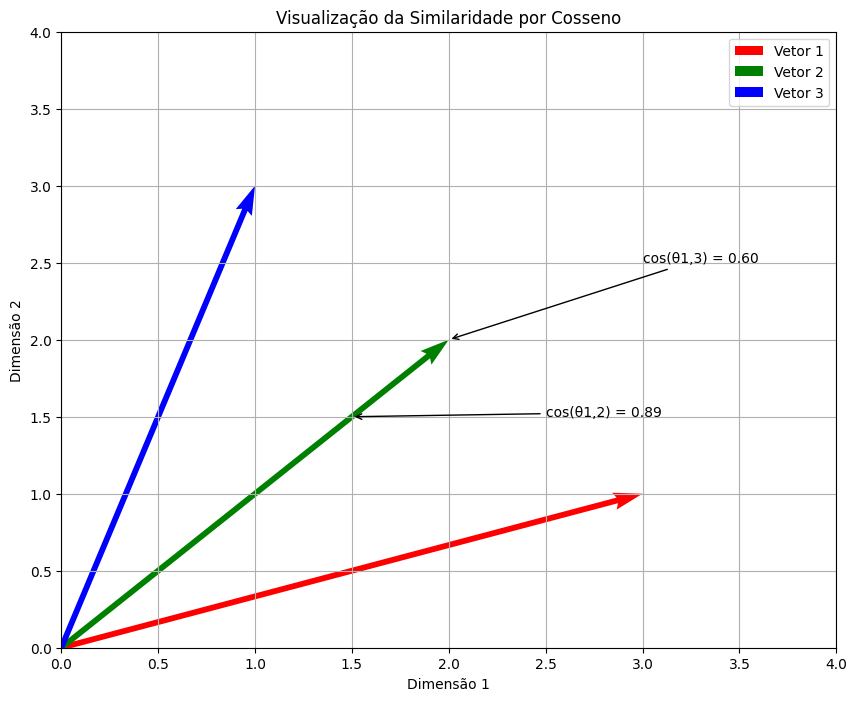

Similaridade por cosseno entre Vetor 1 e Vetor 2: 0.8944
Similaridade por cosseno entre Vetor 1 e Vetor 3: 0.6000

Observação: Quanto mais próximo de 1, mais similar são os vetores.


In [ ]:

model = NearestNeighbors(metric='cosine')
model.fit(books_data.values)

def plot_cosine_similarity():
    
    vector1 = np.array([3, 1])
    vector2 = np.array([2, 2])
    vector3 = np.array([1, 3])
    
   
    plt.figure(figsize=(10, 8))
    plt.quiver(0, 0, vector1[0], vector1[1], angles='xy', scale_units='xy', scale=1, color='r', label='Vetor 1')
    plt.quiver(0, 0, vector2[0], vector2[1], angles='xy', scale_units='xy', scale=1, color='g', label='Vetor 2')
    plt.quiver(0, 0, vector3[0], vector3[1], angles='xy', scale_units='xy', scale=1, color='b', label='Vetor 3')
    
    cos_sim_1_2 = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
    cos_sim_1_3 = np.dot(vector1, vector3) / (np.linalg.norm(vector1) * np.linalg.norm(vector3))
    
    plt.annotate(f'cos(θ1,2) = {cos_sim_1_2:.2f}', xy=(1.5, 1.5), xytext=(2.5, 1.5),
                 arrowprops=dict(arrowstyle='->'))
    plt.annotate(f'cos(θ1,3) = {cos_sim_1_3:.2f}', xy=(2, 2), xytext=(3, 2.5),
                 arrowprops=dict(arrowstyle='->'))
    
    plt.xlim(0, 4)
    plt.ylim(0, 4)
    plt.grid(True)
    plt.legend()
    plt.title('Visualização da Similaridade por Cosseno')
    plt.xlabel('Dimensão 1')
    plt.ylabel('Dimensão 2')
    plt.show()
    
    print(f"Similaridade por cosseno entre Vetor 1 e Vetor 2: {cos_sim_1_2:.4f}")
    print(f"Similaridade por cosseno entre Vetor 1 e Vetor 3: {cos_sim_1_3:.4f}")
    print("\nObservação: Quanto mais próximo de 1, mais similar são os vetores.")


plot_cosine_similarity()

## 5. Geração de Recomendações

O processo de geração de recomendações envolve:
1. Encontrar o livro de referência na matriz de dados
2. Usar o modelo KNN para encontrar os K livros mais similares
3. Calcular os scores de similaridade (1 - distância)
4. Retornar as recomendações ordenadas por similaridade

Vamos implementar esse processo:

In [ ]:
def get_recommendations(book_title, n_recommendations=10):
    """
    Obtém recomendações de livros similares ao título fornecido.
    
    Args:
        book_title: Título do livro para buscar recomendações
        n_recommendations: Número de recomendações desejadas
        
    Returns:
        Lista de BookRecommendation com as recomendações
    """
    try:
        if book_title not in books_data.index:
            print(f"Livro '{book_title}' não encontrado na base de dados")
            return []
        
        idx = books_data.index.get_loc(book_title)
        book_values = books_data.iloc[idx, :].values.reshape(1, -1)
        
        distances, indices = model.kneighbors(book_values, n_recommendations + 1)
        
        recommendations = []
        for distance, index in zip(distances.flatten()[1:], indices.flatten()[1:]):
            recommendations.append(
                BookRecommendation(
                    title=books_data.index[index],
                    similarity_score=1 - distance  
                )
            )
        
        return recommendations
        
    except Exception as e:
        print(f"Erro ao gerar recomendações: {str(e)}")
        return []

# Exemplo de uso
book_title = "Jewel" 
recommendations = get_recommendations(book_title, n_recommendations=5)

print(f"\nRecomendações para: {book_title}\n")
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec.title} (Score: {rec.similarity_score:.3f})")


Recomendações para: Jewel

1. We Were the Mulvaneys (Score: 0.181)
2. Vinegar Hill (Oprah's Book Club (Paperback)) (Score: 0.179)
3. River, Cross My Heart (Score: 0.155)
4. The Reader (Score: 0.153)
5. Songs in Ordinary Time (Oprah's Book Club (Paperback)) (Score: 0.149)


## 7. Experimentação com Diferentes Livros

Vamos testar o sistema com diferentes livros e analisar os resultados:

In [ ]:

test_books = [
    "Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))",
    "The Da Vinci Code",
    "To Kill a Mockingbird",
    "The Hobbit : The Enchanting Prelude to The Lord of the Rings"
]


for book in test_books:
    if book in books_data.index:
        print(f"\n{'='*80}\nRecomendações para: {book}\n{'='*80}")
        recs = get_recommendations(book, n_recommendations=5)
        for i, rec in enumerate(recs, 1):
            print(f"{i}. {rec.title} (Score: {rec.similarity_score:.3f})")
        
        
        print(book, recs)
    else:
        print(f"\nLivro '{book}' não encontrado na base de dados")
        
        
        similar_titles = [title for title in books_data.index if book.lower() in title.lower()]
        if similar_titles:
            print("Você quis dizer um destes?")
            for i, title in enumerate(similar_titles[:5], 1):
                print(f"{i}. {title}")


Recomendações para: Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
1. Harry Potter and the Chamber of Secrets (Book 2) (Score: 0.338)
2. Harry Potter and the Prisoner of Azkaban (Book 3) (Score: 0.283)
3. Harry Potter and the Goblet of Fire (Book 4) (Score: 0.207)
4. Harry Potter and the Goblet of Fire (Book 4) (Score: 0.204)
5. Harry Potter and the Order of the Phoenix (Book 5) (Score: 0.199)
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)) [BookRecommendation(title='Harry Potter and the Chamber of Secrets (Book 2)', similarity_score=0.3376469612121582), BookRecommendation(title='Harry Potter and the Prisoner of Azkaban (Book 3)', similarity_score=0.283186137676239), BookRecommendation(title='Harry Potter and the Goblet of Fire (Book 4)', similarity_score=0.20661771297454834), BookRecommendation(title='Harry Potter and the Goblet of Fire (Book 4)', similarity_score=0.20366549491882324), BookRecommendation(title='Harry Potter and the Order of the Phoe

## 8. Conclusão e Limitações

### Pontos Fortes do Sistema
- Utiliza um algoritmo eficiente (KNN) para encontrar livros similares
- Filtra dados para melhorar a qualidade das recomendações
- Implementa uma métrica de similaridade adequada para dados esparsos

### Limitações
1. **Problema de Cold Start**: Novos livros ou usuários com poucas avaliações não são bem representados
2. **Esparsidade dos Dados**: A maioria dos usuários avalia poucos livros, resultando em uma matriz esparsa
3. **Viés de Popularidade**: Livros populares tendem a ser mais recomendados
4. **Falta de Contexto**: O sistema não considera o conteúdo dos livros, apenas os padrões de avaliação



Esparsidade da matriz: 0.9930 (99.30%)
Número total de elementos: 4447240
Número de elementos não-zero: 30914
Número de livros: 490
Número de usuários: 9076


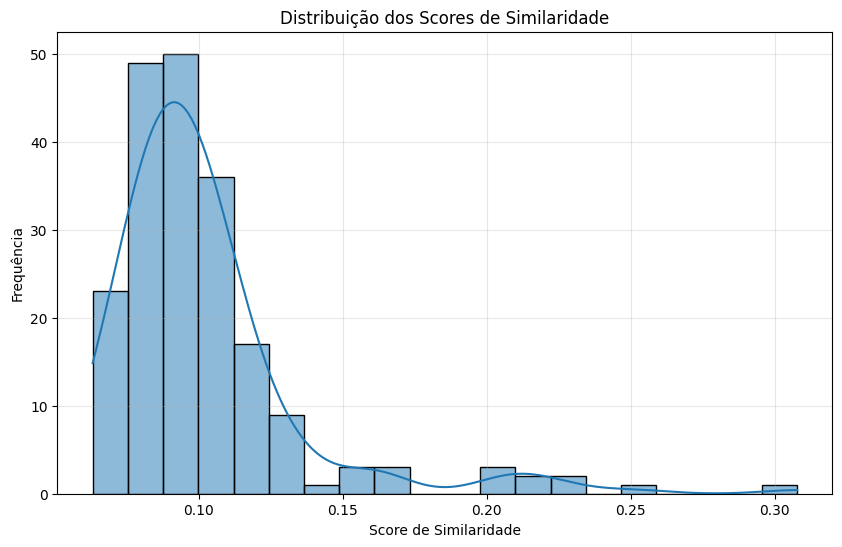

In [ ]:

sparsity = 1.0 - np.count_nonzero(books_data.values) / books_data.size
print(f"Esparsidade da matriz: {sparsity:.4f} ({sparsity*100:.2f}%)")
print(f"Número total de elementos: {books_data.size}")
print(f"Número de elementos não-zero: {np.count_nonzero(books_data.values)}")
print(f"Número de livros: {books_data.shape[0]}")
print(f"Número de usuários: {books_data.shape[1]}")


all_scores = []
for book in books_data.index[:20]:
    recs = get_recommendations(book, n_recommendations=10)
    all_scores.extend([rec.similarity_score for rec in recs])

plt.figure(figsize=(10, 6))
sns.histplot(all_scores, bins=20, kde=True)
plt.title('Distribuição dos Scores de Similaridade')
plt.xlabel('Score de Similaridade')
plt.ylabel('Frequência')
plt.grid(True, alpha=0.3)
plt.show()